In [1]:
%load_ext autoreload
%autoreload 2

using device None
GPU 0/2 memory: free=6.140, total=10.917
init rendererGPU 0/2 memory: free=2.081, total=10.917

K: 0.0
action_scale: (0.015, 0.015, 0.015, 0.05, 0.05, 0.05, 0.015)
av: (0.01, 0.01, 0.01)
color: (0.3, 0.3, 0.3)
friction: 20.0
lv: (0.01, 0.01, 0.01)
mode: Box
size: (0.02, 0.15, 0.02)
softness: 666.0


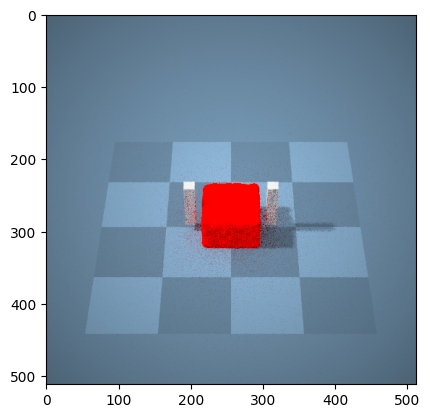

In [9]:
from envs import MultiToolEnv, WorldState
from envs import test_utils as tu
import numpy as np


env = MultiToolEnv(sim_cfg=dict(max_steps=1024))
tu.init_scene(env, 0)
state = env.get_state()
state = state.switch_tools('Gripper', np.array([0.5, 0.1, 0.5, 0., 0., 0., 1.3]), friction=20.)
env.set_state(state)
env.render('plt')

In [ ]:
env.set_state(state)
images = []
for i in range(100):
    env.step([0., 1. if i>50 else 0., 0., 0., 0., 0., -1. if i < 40 else 0.])
    images.append(env.render('rgb_array'))

from tools.utils import animate
animate(images)

In [ ]:
import torch
from torch import nn, optim
from tools.utils import totensor

torch.autograd.set_detect_anomaly(True)

actions = nn.Parameter(totensor(np.zeros((50, 7)), 'cuda:0'), requires_grad=True)
adam = optim.Adam([actions], lr=0.1)

import tqdm
for i in tqdm.trange(20):
    adam.zero_grad()
    env.set_state(state, requires_grad=True)
    loss = 0
    for i in range(50):
        env.step(actions[i])
        obs = env.get_obs()
        loss = loss - obs['pos'].mean(axis=0)[1] + torch.relu(obs['dist'].min(axis=0).values).sum()

    print(loss)
    loss.backward()
    adam.step()
    actions.data.clamp_(-1, 1)

In [ ]:
env.set_state(state)
images = []
for i in range(50):
    env.step(actions[i].detach())
    images.append(env.render('rgb_array'))

animate(images, 'tmp2.mp4')

In [ ]:
env.set_state(state, requires_grad=True)
adam.zero_grad()
loss = 0
for i in range(50):
    env.step(actions[i])
    obs = env.get_obs()
    if i == 30:
        loss = loss - obs['pos'].mean(axis=0)[1] + torch.relu(obs['dist'].min(axis=0).values).sum()

print(loss)
loss.backward()
grad = actions.grad.detach().cpu().numpy()

state5 = env.get_state(index=5 * 20)

In [ ]:
env.set_state(state5, requires_grad=True)

adam.zero_grad()
loss = 0
for i in range(40):
    env.step(actions[i+5])
    obs = env.get_obs()
    if i == 25:
        loss = loss - obs['pos'].mean(axis=0)[1] + torch.relu(obs['dist'].min(axis=0).values).sum()

print(loss)
loss.backward()
grad2 = actions.grad.detach().cpu().numpy()

In [ ]:
print(grad[5:25][0])
print(grad2[5:25][0])